## Introduction

### Overview

In the fast-paced world of e-commerce, the ability to predict market trends and sales dynamics offers a significant competitive advantage. This report aims to provide a comprehensive analysis of sales and product trends within our marketplace, focusing on forecasting the performance of both sellers and products based on historical data. The insights derived from this analysis will help inform strategic decisions, optimize inventory management, and enhance marketing efforts.

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Function to load and prepare data from CSV files

In [24]:
def load_and_prepare_data(order_path, order_items_path, products_path):
    try:
        orders = pd.read_csv(order_path)
        order_items = pd.read_csv(order_items_path)
        products = pd.read_csv(products_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

    try:
        # Merging the datasets on appropriate keys
        merged = pd.merge(order_items, orders, on='order_id')
        merged = pd.merge(merged, products, on='product_id')
        # Converting timestamps to date
        merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp']).dt.date
        # Aggregating sales data by product category and purchase date
        daily_sales = merged.groupby(['product_category_name', 'order_purchase_timestamp'])['order_item_id'].sum().reset_index()
        daily_sales.rename(columns={'order_purchase_timestamp': 'date', 'order_item_id': 'sales'}, inplace=True)
        daily_sales['date'] = pd.to_datetime(daily_sales['date'])
        return daily_sales
    except Exception as e:
        print(f"Error processing data: {e}")
        return pd.DataFrame()


# Check if there is sufficient data available for forecasting

In [25]:
def check_data_availability(series):
    return not series.empty and not series.isnull().all()


# Function to fit an ARIMA model and make a forecast

In [26]:
def auto_fit_arima(series):
    if not check_data_availability(series):
        print("No data available for ARIMA model.")
        return None
    # Automatically fit an optimal ARIMA model
    model = auto_arima(series, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True)
    fitted_model = model.fit(series)
    # Forecasting the next 14 periods
    forecast = fitted_model.predict(n_periods=14)
    return forecast

# Function to train a Random Forest model

In [27]:
def train_random_forest(data):
    # Extracting date-related features for the Random Forest model
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    X = data[['day_of_week', 'month', 'day']]
    y = data['sales']
    # Training the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

# Function to make a forecast using the trained Random Forest model

In [28]:
def forecast_with_rf(model, days=14):
    last_date = pd.to_datetime("today")
    # Creating future dates for prediction
    future_dates = pd.date_range(start=last_date, periods=days+1, freq='D')[1:]
    future_data = pd.DataFrame({
        'day_of_week': future_dates.dayofweek,
        'month': future_dates.month,
        'day': future_dates.day
    })
    # Making predictions for the future dates
    predictions = model.predict(future_data)
    return predictions, future_dates

# Function to plot the forecasts

In [30]:
def plot_forecasts(dates, forecasts, title):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, forecasts, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Forecasted Sales')
    plt.grid(True)
    plt.show()

# Main execution block

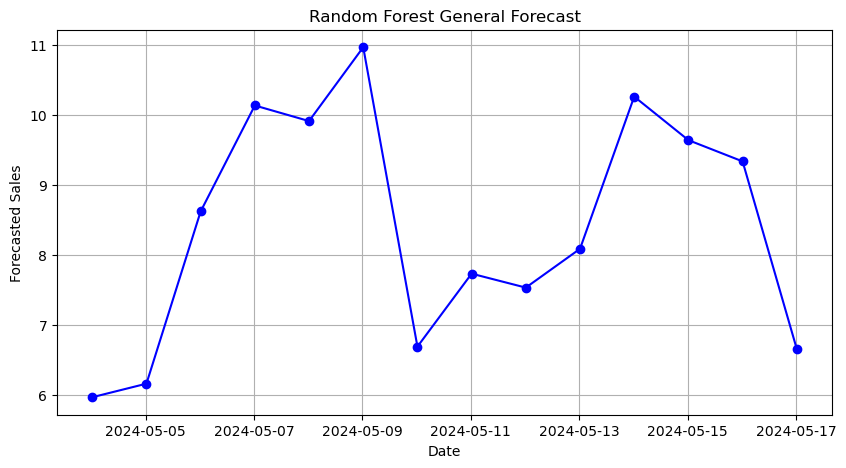

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6072.227, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5634.795, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5840.682, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5558.591, Time=0.87 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5765.269, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5514.876, Time=0.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5587.806, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.20 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5493.524, Time=1.50 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=5565.8

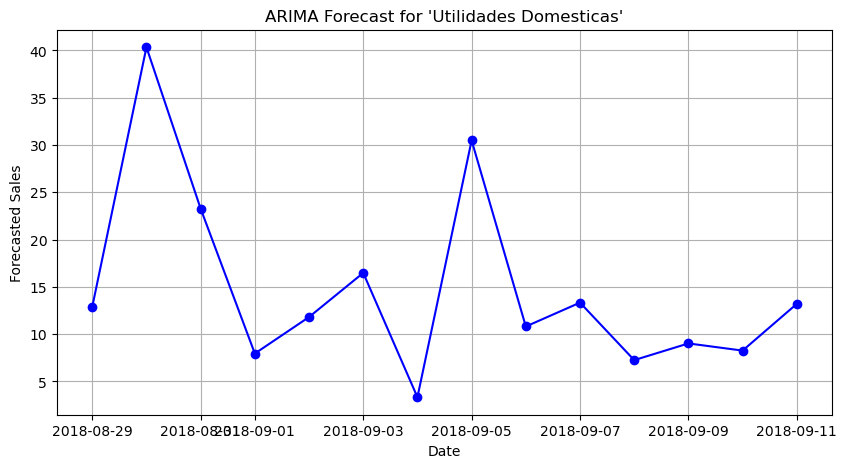

In [31]:
daily_sales = load_and_prepare_data('orders.csv', 'order_items.csv', 'products.csv')

if not daily_sales.empty:
    # Training and forecasting with Random Forest
    rf_model = train_random_forest(daily_sales)
    rf_forecast, rf_dates = forecast_with_rf(rf_model)
    plot_forecasts(rf_dates, rf_forecast, "Random Forest General Forecast")

    # Selecting a category with sufficient data and performing ARIMA forecasting
    category_series = daily_sales[daily_sales['product_category_name'] == 'utilidades_domesticas'].set_index('date').asfreq('D', fill_value=0)['sales']
    if check_data_availability(category_series):
        forecast_arima = auto_fit_arima(category_series)
        if forecast_arima is not None:
            arima_dates = pd.date_range(start=category_series.index[-1], periods=15, freq='D')[1:15]
            plot_forecasts(arima_dates, forecast_arima, "ARIMA Forecast for 'Utilidades Domesticas'")
        else:
            print("ARIMA model could not be fitted.")
    else:
        print("No sufficient data to run ARIMA model.")
else:
    print("Failed to load any data.")

# Rationale for choice of methods

### ARIMA: Ideal for analyzing and predicting temporal data with clear seasonal patterns and trends, and does well in modeling historical data.

### Random Forest: Effective for modeling non-linear relationships between features and outcomes, suitable for predicting based on features extracted from dates and other metadata. Does well at predicting sales for new products due to its ability to make general inferences based on other categories and their features.



# Result

### The code integrates two different approaches to forecasting, providing the ability to make predictions for both existing data and new products, according to project requirements. The use of historical data and features derived from the calendar enables effective and flexible forecasting of short term sales.